# 장고를 이용하여 게시판 앱 만들기

## 탬플릿 생성하기

* board모델 데이터를 템플릿 파일(HTML)을 활용하여 화면에 출력할 수 있도록 views.py에서 render함수를 활용한다.
* render함수는 context에 있는 Board모델 데이터 board_list를 탬플릿 (bbsnote/board_list.html)에 적용하여 출력

In [ ]:
# vs code 사용
# bbsnote/views.py파일에 추가
from django.shortcuts import render
from django.http import HttpResponse
# 현재 디렉토리의 models모듈에서 Board클래스를 불러옴 DB의 테이블
from .models import Board

# Create your views here.
def index(request):
    # Board객체 목록을 생성날짜의 역순으로 정렬하여 가져옴
    board_list = Board.objects.order_by('-create_date')
    context = {'board_list': board_list}
    # return HttpResponse("bbsnote에 오신것을 환영합니다!")
    # 탬플릿 파일 'bbsnote/board_list.html'을 랜더링하여 HTTP 응답 객체를 반환
    return render(request, 'bbsnote/board_list.html', context)

* 모델 데이터를 랜더링하기 위해 작성"된 html템플릿 파일을 저장하기 위해 디렉토리를 만들고, 위치를 등록한다.
* 프로젝트폴더 내에 templates폴더가 위치해야 하며, 그 하위에 앱이름인 bbsnote폴더를 한번 더 만들어서 템플릿을 저장

In [ ]:
# config/settings.py파일 수정
# "DIRS":[]부분에 생성한 templates의 경로를 적어준다
TEMPLATES = [
    {
        "BACKEND": "django.template.backends.django.DjangoTemplates",
        "DIRS": [BASE_DIR/'templates'],
        "APP_DIRS": True,
        "OPTIONS": {
            "context_processors": [
                "django.template.context_processors.debug",
                "django.template.context_processors.request",
                "django.contrib.auth.context_processors.auth",
                "django.contrib.messages.context_processors.messages",
            ],
        },
    },
]


* 템플릿 태그: {% 와 %}로 둘러싸인 문장
* 템플릿 변수: {{}}로 둘러싸인 값

In [ ]:
# templates/bbsnote/의 경로에 board_list.html파일 생성 후 작성
{% if board_list %}
    <ul>
        {% for board in board_list %}
        <li><a href="/bbsnote/{{board.id}}/">{{board.subject}}</a></li>
        {% endfor %}
    </ul>
{% else %}
    <p>글이 없습니다.</p>
{% endif %}

## 상세 페이지 기능 구현

In [ ]:
# bbsnote/urls.py에서 추가
from django.urls import path
from . import views

urlpatterns = [
    # 첫번째 URL패턴이 빈 문자열이고 일치할 경우 views.index 뷰 함수 호출
    path('', views.index)
    # int는 path_converter라 부르는 기능, board_id는 컨버터를 통해 반환(int는 board_id에 숫자가 매핑되었음을 의미)
    # <type:name>으로 작성, 지정한 타입의 name변수를 view함수로 넘기는 역할을 함
    # 두번째 URL패턴이 정수형 변수인 board_id와 매칭하며, 일치할 경우 views.detail 뷰 함수 호
    path('<int:board_id>/', views.detail),
]

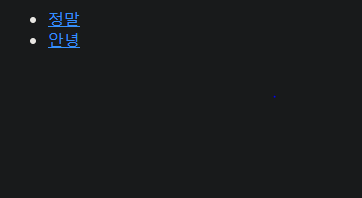

* 게시글에 커서를 대면 왼쪽아래 상태표시줄에 해당글의 인덱스번호도 같이 출력되는 것을 알 수 있다.

### 기본 제공되는 컨버터 종류
1. str: 비어있지 않은 모든 숫자와 매칭('/'는 제외, 컨버터를 설정하지 않은 경우 default)
2. int: 0 이상인 양의 정수와 매칭
3. slug: 영문 대소문자와 숫자, -과_을 갖는 문자열 패턴
4. uuid: UUID와 매칭(모든 문자가 소문자여야 하고 -포함 되어야함), 같은 페이지에 여러 URL이 연결되는 것을 막기 위해 사용
5. path: 기본적으로 str과 같은 기능이나 '/'도 포함한다. URL의 부분이 아닌 전체에 대한 매칭을 하고 싶을 때 사용

In [ ]:
# bbsnote/views.py에서 detail함수 정의
def detail(request, board_id):
    # Board에서 id가 board_id인 Board객체를 가져온다
    # Board.objects' -> SELECT * FROM bbsnote_Board
    # get(id=board_id) -> WHERE id=board_id;
    board = Board.objects.get(id=board_id)
    context = {'board': board}
    return render(request, 'bbsnote/board_detail.txt', context)

In [ ]:
# templates/bbsnote/의 경로에 board_detsil.html파일 생성 후 작성
<h1>{{board.subject}}</h1>
<div>
    {{board.content}}
</div>

* 저장 후 웹 서버을 가보면 h1부분의 크기와 div의 구분이 잘 시행되어짐을 알 수 있다.

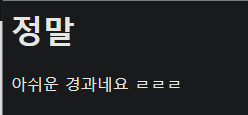

## URL별칭 사용하기

* app_name변수에 네임스페이스 - 각각의 앱이 관리하는 독립된 이름공간 - 를 정의한다.
* path함수에 있는 URL매핑에 name속성을 부여
* 네임스페이스를 이용함으로써 각 앱 별로 동일한 name이 부여되도 구분이 된다.

In [ ]:
# bbsnote/urls.py에서 수정
# 앱의 이름을 'bbsnote'로 선언, 이 이름은 URL 패턴의 네임스페이스로 사용
app_name = 'bbsnote'

urlpatterns = [
    path('', views.index, name='index'),
    path('<int:board_id>/', views.detail, name='detail'),
]

In [ ]:
# 별칭을 부여했으므로 templates/bbsnote/board_list.htmldml의 내용 수정
{% if board_list %}
    <ul>
        {% for board in board_list %}
        <li><a href = "{% url 'bbsnote:detail' board.id %}">{{board.subject}}</a></li>
        {% endfor %}
    </ul>
{% else %}
    <p>글이 없습니다.</p>
{% endif %}

* 단지 별칭을 부여하고 수정한 작업이므로 웹서버에서는 차이가 없다.

## 댓글 구현하기

In [ ]:
# bbsnote/urls.py에서 추가하기
from django.urls import path
from . import views

urlpatterns = [
    path('', views.index)
    path('<int:board_id>/', views.detail),
    # 세번째 URL패턴이 'comment/create/'문자열 다음에 정수형 변수인 board_id와 매칭
    # 일치할 경우 views.comment_create 뷰 함수 호출
    path('comment/create/<int:board_id>/', views.comment_create, name='comment_create'),
]

In [ ]:
# bbsnote/views.py에서도 댓글추가를 위한 함수를 정의해준다
# 방법 1
from django.shortcuts import render, redirect
# from django.http import HttpResponse
from .models import Board, Comment
from django.utils import timezone
def comment_create(request, board_id):
    board = Board.objects.get(id=board_id)
    # content속성은 POST데이터 중 content 키의 값으로 설정
    comment = Comment(board=board, content=request.POST.get('content'), create_date=timezone.now())
    comment.save()
    # 'bbsnote:detail'이라는 URL 패턴으로 리디렉션하고 board_id라는 인자로 board.id값 전달
    # 사용자가 특정 게시판의 세부 정보 페이지로 이동할 수 있음
    return redirect('bbsnote:detail', board_id=board.id)

* 앞서 comment클래스를 구현시, comment의 board는 board클래스의 board를 foreign_key로 연결되어 있는 상태이다.
* foreign_key로 연결된 모델의 경우 '연결모델명_set' 형태로 연결된 데이터를 조회하거나 등록 할 수 있다.
* Board모델을 통해 Coomment모델 데이터 생성을 위해 board.comment_set.create 사용

In [ ]:
# 방법 2
from django.shortcuts import render, redirect
# from django.http import HttpResponse
from .models import Board, Comment
from django.utils import timezone
def comment_create(request, board_id):
    board = Board.objects.get(id=board_id)
    board.comment_set.create(content=request.POST.get('content'), create_date=timezone.now())
    return redirect('bbsnote:detail', board_id=board.id)

### csrf_token(Cross Site Request Forgery)
* csrf 공격을 막기 위해 form 태그아래에 반드시 작성해준다.
* form태그를 통해 전송된 데이터가 실제 브라우저에서 작성된 데이터인지 판단
* 데이터의 신뢰성을 위해 csrf_token선언은 꼭 필요하다.

In [ ]:
# 댓글을 구현하기 위한 html내용을 추가해준다.
# tmeplates/bbsnote/board_detail.html에 추가
<h1>{{board.subject}}</h1>
<div>
    {{board.content}}
</div>
<div>
    <ul>
        {% for comment in board.comment_set.all %}
        <li>{{comment.content}}</li>
        {% endfor %}
    </ul>
</div>
<form action="{% url 'bbsnote:comment_create' board.id %}" method="post">
    # <!-- form태그안에 csrf_token을 선언해 주어야 한다 -->
    # <!-- csrf의 공격을 막기위해, 데이터의 신뢰성을 위해 -->
    {% csrf_token %}
    <textarea name="content" id="content" rows="15"></textarea>
    <input type="submit" value="댓글달기">
</form>

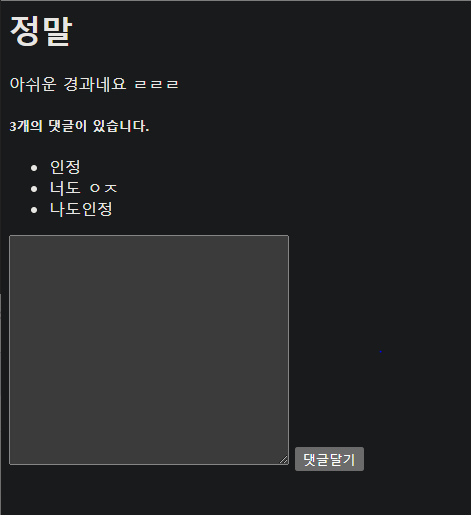

* 위와 같이 댓글을 달 수 있는 공간과 '댓글달기'버튼을 통해 댓글을 등록할 수 있게 되었다.